In [1]:
import sys
import importlib
sys.path.append("../unilasso")

import plotting
importlib.reload(plotting)

import summary
importlib.reload(summary)

import model
importlib.reload(model)

<module 'model' from '/home/jhaberbe/Projects/Personal/unilasso/notebook/../unilasso/model.py'>

# Paper and Goal

Original Paper [ here ](https://arxiv.org/abs/2501.18360)


Given some dataset where the number of features is much greater than the number of samples ("underdetermined"), we would like to have some system to solve high-dimensional regression that:
- produces _sparse_ solutions 
    - a few features that are predicted to contribution to the outcome. 
- produces _interpretable_ solutions 
    - a person can quickly look at these parameters and understand what they're supposed to mean.

Below is going to be an example of a regression task that we would want to solve for.

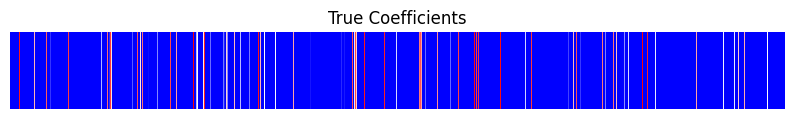

In [2]:
import pandas as pd
import pandas as pd
from sklearn.datasets import make_regression

# Under-determined, noisy regression task. Lets suppose 100 features are informative, and the rest are noise.
X, y, coef = make_regression(n_samples=200, n_features=1000, noise=.3, coef=True, n_informative=100, shuffle=True, random_state=42)

# Dataset
df = pd.DataFrame(X, columns=[f"x{i}" for i in range(X.shape[1])])
df["y"] = y

# Plotting the true coefficients, to show the sparsity
plotting.plot_coefficient_vector(coef, title="True Coefficients")

# Prior Approaches (Mostly LASSO Regression) 

Typically, if you're interested in inducing sparsity, you use LASSO (L1 penalization). However, LASSO does have some limitations:
- In a system of correlated predictors, LASSO will tend to distribute weight to multiple predictors rather than choose one (Though one can use LASSO with Least Angle Regression to tackle this).
- There can be inclusion of spurious features, which could be due to a number of reasons such as:
    - Noisiness in data
    - High dimensionality (p >> n)

# **Algorithm: Leave-One-Out Univariate Regression + Non-negative Lasso**

Given:
- Data matrix $ X \in \mathbb{R}^{n \times p} $, with $ n $ samples and $ p $ features.

Steps:

1. Initialize a new feature matrix $ F \in \mathbb{R}^{n \times p} $

2. For each feature $ j = 1, \ldots, p $:
   - For each sample $ i = 1, \ldots, n $:
     - Exclude sample $ i $ from the dataset.
     - Fit a univariate linear regression model to the other $ n - 1 $ samples:
       $$
       X_{k,j} = \beta_0^{(i,j)} + \beta_1^{(i,j)} \cdot k + \varepsilon_k, \quad \text{for } k \ne i
       $$
     - Predict the held-out value:
       $$
       \hat{X}_{i,j} = \beta_0^{(i,j)} + \beta_1^{(i,j)} \cdot i
       $$
     - Set $ F_{i,j} := \hat{X}_{i,j} $

3. Fit a non-negative Lasso model with cross-validation:
   $$
   \hat{\beta} = \arg\min_{\beta \ge 0} \left\| Y - F \beta \right\|_2^2 + \lambda \|\beta\|_1
   $$

__Its a lot easier to just look at code!__

In [ ]:
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, LassoCV

# Scikit-learn type interface
class UniLasso:
    def __init__(self):
        # Here we'll store the intercepts, coefficients, and fitted values for the univariate models.
        self.intercepts_ = None
        self.coef_ = None
        self.F_ = None

        # We use LassoCV to select the best regularization parameter.
        # We set positive=True to ensure that coefficients are non-negative.
        self.lasso = LassoCV(positive=True, alphas=100, cv=5, max_iter=10000, tol=1e-4, n_jobs=-1, fit_intercept=False)
    
    def fit(self, X, y):
        # Initialize the intercepts, coefficients, and fitted values matrix based on the input shape.
        self.intercepts_ = np.zeros(X.shape[1], dtype=float)
        self.coef_ = np.zeros(X.shape[1], dtype=float)
        self.F_ = np.zeros_like(X, dtype=float)

        # Over all the features.
        for j in tqdm(range(X.shape[1])):

            # Center the matrix
            xj = X[:, j]
            xj_centered = xj - xj.mean()
            hat_diag = xj_centered**2 / np.sum(xj_centered**2)

            # Get our linear regression fit.
            beta = np.sum(xj_centered * y) / np.sum(xj_centered**2)
            intercept = y.mean() - beta * xj.mean()

            # Generate predictions for the current feature.
            y_pred = intercept + xj * beta

            # Store the intercept and coefficient for predictions on unseen data.
            self.intercepts_[j] = intercept
            self.coef_[j] = beta

            # Update the fitted values matrix, this is a trick to avoid recomputing the entire system each time.
            self.F_[:, j] = y_pred - hat_diag * (y_pred - y) / (1 - hat_diag)

        self.lasso.fit(self.F_, y)
    
    def predict(self, X):
        # Rebuild the F matrix based on training-time univariate fits
        # This assumes we're working with unseen data data.
        F_new = X * self.coef_ + self.intercepts_  # elementwise per feature
        return self.lasso.predict(F_new)

    def score(self, y):
        # Rebuild the F matrix based on training-time univariate fits
        # This assumes we're working with unseen data data.
        return self.lasso.score(self.F_, y)

# Predictions

In [4]:
from sklearn.model_selection import train_test_split

# Test the model with a train-test split, 70/30 like they do in the paper.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
# We can now use the UniLasso class to fit our model and make predictions on unseen data.
unilasso = model.UniLasso()
unilasso.fit(X_train, y_train)
unilasso_predictions = unilasso.predict(X_test)

# For comparison, we can also fit a standard Lasso model with CV in the same fashion.
vanilla_lasso = LassoCV()
vanilla_lasso.fit(X_train, y_train)
lasso_predictions = vanilla_lasso.predict(X_test)

# Output Summary.

In terms of MSE, they perform comparably.

UniLasso MSE: 380799.8225676367
Vanilla Lasso MSE: 312524.3068726582


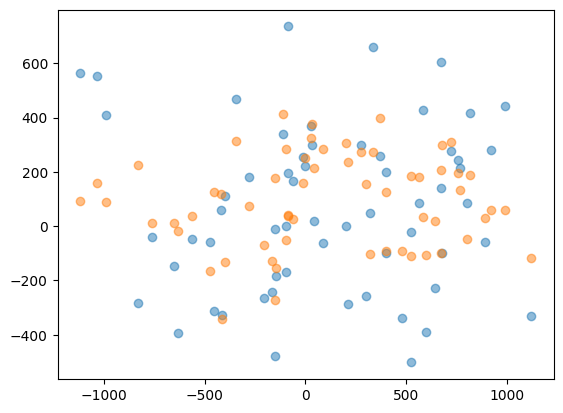

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

plt.scatter(y_test, unilasso_predictions, label="UniLasso Predictions", alpha=0.5)
plt.scatter(y_test, lasso_predictions, label="UniLasso Predictions", alpha=0.5)

# Compute MSE for UniLasso predictions
mse_unilasso = mean_squared_error(y_test, unilasso_predictions)

# Compute MSE for Vanilla Lasso predictions
mse_lasso = mean_squared_error(y_test, lasso_predictions)

print("UniLasso MSE:", mse_unilasso)
print("Vanilla Lasso MSE:", mse_lasso)

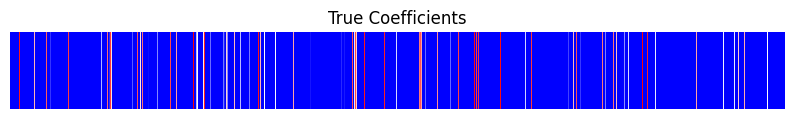

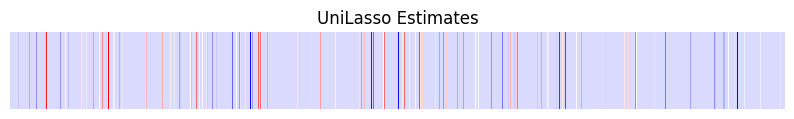

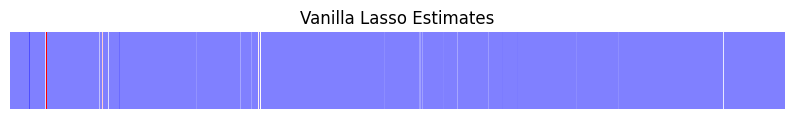

In [9]:
plotting.plot_coefficient_vector(coef, title="True Coefficients")
plotting.plot_coefficient_vector(unilasso.coef_ * unilasso.lasso.coef_, title="UniLasso Estimates")
plotting.plot_coefficient_vector(vanilla_lasso.coef_, title="Vanilla Lasso Estimates")

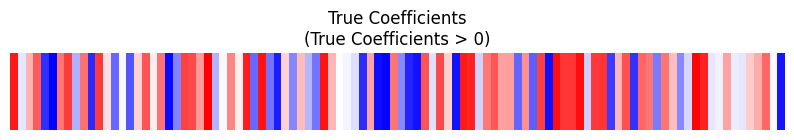

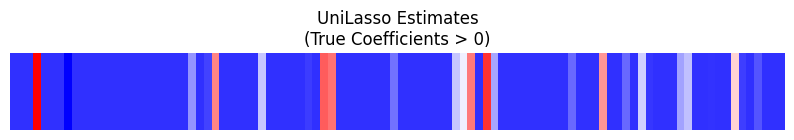

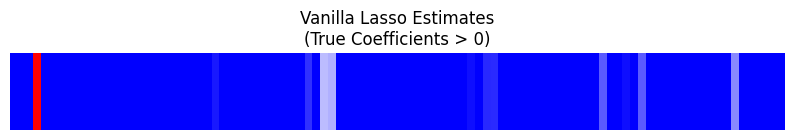

In [594]:
plotting.plot_coefficient_vector(coef[coef > 0], title="True Coefficients\n(True Coefficients > 0)")
plotting.plot_coefficient_vector((unilasso.coef_ * unilasso.lasso.coef_)[coef > 0], title="UniLasso Estimates\n(True Coefficients > 0)")
plotting.plot_coefficient_vector(vanilla_lasso.coef_[coef > 0], title="Vanilla Lasso Estimates\n(True Coefficients > 0)")

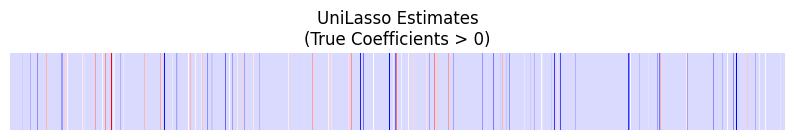

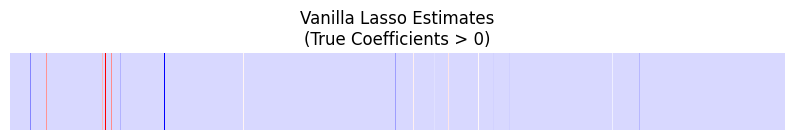

In [595]:
plotting.plot_coefficient_vector((unilasso.coef_ * unilasso.lasso.coef_)[coef == 0], title="UniLasso Estimates\n(True Coefficients > 0)")
plotting.plot_coefficient_vector(vanilla_lasso.coef_[coef == 0], title="Vanilla Lasso Estimates\n(True Coefficients > 0)")

# Testing each method

Since the value (at least for me) of a method like this is how well it can recover statistically significant associations, I'm going to be testing the PPV and the F1 score for both of these models.

One fun thing to note about UniLasso is that it is actually much more numerically stable (Fewer N/As). The F1 scores tend to be higher for UniLasso, but shows worse PPV. This is probably in part due to UniLasso (in their paper) producing far sparser feature sets. While this is at the expense of MSE, the hope is that the few features it chooses are highly relevant!

In [596]:
ppv = {}
f1_scores = {}

for i in tqdm(range(100)):
    # Under-determined, noisy regression task. Lets suppose 20 features are informative, and the rest are noise.
    X, y, coef = make_regression(n_samples=81, n_features=1000, noise=.1, coef=True, n_informative=100, shuffle=True)

    # Dataset
    df = pd.DataFrame(X, columns=[f"x{i}" for i in range(X.shape[1])])
    df["y"] = y

    # We can now use the UniLasso class to fit our model and make predictions on unseen data.
    unilasso = model.UniLasso()
    unilasso.fit(X_train, y_train)
    unilasso_predictions = unilasso.predict(X_test)

    # Test the model with a train-test split, 70/30 like they do in the paper.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # For comparison, we can also fit a standard Lasso model with CV in the same fashion.
    vanilla_lasso = LassoCV()
    vanilla_lasso.fit(X_train, y_train)
    lasso_predictions = vanilla_lasso.predict(X_test)

    summary_table = pd.concat([
        summary.coef_evaluation_table(coef, unilasso.coef_ * unilasso.lasso.coef_),
        summary.coef_evaluation_table(coef, vanilla_lasso.coef_),
    ])

    summary_table.index = ["UniLasso", "Vanilla Lasso"]
    summary_table

    f1_scores[i] = summary_table["F1"]
    ppv[i] = summary_table["PPV"]

  4%|▍         | 4/100 [00:01<00:32,  2.94it/s]/Users/jameshaberberger/GitHub/unilasso/notebook/../unilasso/summary.py:21: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rank_corr, _ = spearmanr(true_coef, est_coef)
  6%|▌         | 6/100 [00:02<00:31,  2.97it/s]/Users/jameshaberberger/GitHub/unilasso/notebook/../unilasso/summary.py:21: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rank_corr, _ = spearmanr(true_coef, est_coef)
  9%|▉         | 9/100 [00:03<00:30,  2.99it/s]/Users/jameshaberberger/GitHub/unilasso/notebook/../unilasso/summary.py:21: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rank_corr, _ = spearmanr(true_coef, est_coef)
 14%|█▍        | 14/100 [00:04<00:26,  3.23it/s]/Users/jameshaberberger/GitHub/unilasso/notebook/../unilasso/summary.py:21: ConstantInputWarning: An input array is constant; the correlation coefficient is 

[Text(0, 0.5, 'F1 Score\n(Higher is better)')]

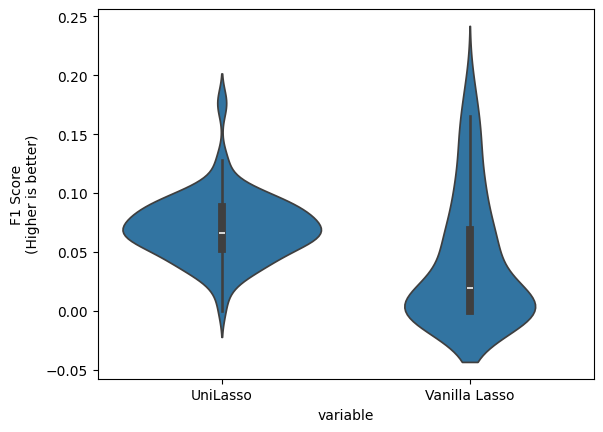

In [541]:
sns.violinplot(
    pd.DataFrame(f1_scores).T.melt(),
    x="variable",
    y="value"
).set(ylabel = "F1 Score\n(Higher is better)")

[Text(0, 0.5, 'PPV\n(Higher is better)')]

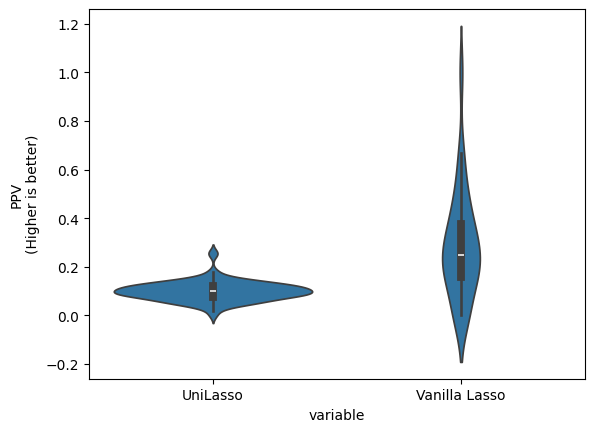

In [542]:
sns.violinplot(
    pd.DataFrame(ppv).T.melt(),
    x="variable",
    y="value"
).set(ylabel = "PPV\n(Higher is better)")